In [ ]:
import copy
import os
import pickle
import time

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, \
    matthews_corrcoef, auc
from sklearn.preprocessing import label_binarize
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from google.colab import drive
# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)

# Hiperparametreler
data_dir = '/content/drive/MyDrive/Data'
batch_size = 64
num_epochs = 100
learning_rate = 0.0005

# Veri dönüşümleri
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Veri setlerinin yüklenmesi
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)  # Sınıf sayısını otomatik olarak ayarla

# Cihazı ayarlama
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CNN modeli tanımlama
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 1024),  # Görüntü boyutu 224x224 olduğu için 256 * 28 * 28
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Tam bağlantı katmanına bağlamak için girdi boyutunu düzleştir
        x = self.classifier(x)
        return x

# Modeli oluşturma ve cihazda çalıştırma
model = SimpleCNN(num_classes=num_classes).to(device)

# Kayıp fonksiyonu ve optimize edici
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Eğitim fonksiyonu (önceki kodunuzdakiyle aynı)
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    metrics = {
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'fpr': [],
        'tpr': [],
        'roc_auc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # TQDM kullanarak ilerleme çubuğu ekleyelim (canlı metrik yok)
            with tqdm(total=len(dataloaders[phase]), desc=f"{phase.capitalize()} Epoch {epoch+1}/{num_epochs}") as pbar:
                for i, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

                    # İlerlemeyi sadece güncelleme için gösteriyoruz
                    pbar.update(1)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            epoch_precision = precision_score(all_labels, all_preds, average='macro')
            epoch_mcc = matthews_corrcoef(all_labels, all_preds)

            # Epoch sonunda metrikleri ekrana yazdır
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Recall: {epoch_recall:.4f} Precision: {epoch_precision:.4f} MCC: {epoch_mcc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                all_labels_bin = label_binarize(all_labels, classes=range(num_classes))
                all_preds_bin = label_binarize(all_preds, classes=range(num_classes))

                for class_index in range(num_classes):
                    fpr, tpr, _ = roc_curve(all_labels_bin[:, class_index], all_preds_bin[:, class_index])
                    roc_auc = auc(fpr, tpr)
                    metrics['fpr'].append(fpr)
                    metrics['tpr'].append(tpr)
                    metrics['roc_auc'].append(roc_auc)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        # Her epoch sonunda son modeli kaydet
        torch.save(model.state_dict(), '/content/drive/MyDrive/cnn/last_model.pth')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    # CNN klasörü
    os.makedirs('cnn', exist_ok=True)

    # Metrikleri kaydet
    with open('/content/drive/MyDrive/cnn/metrics.pkl', 'wb') as f:
        pickle.dump(metrics, f)

    # En iyi modeli kaydet
    torch.save(model.state_dict(), '/content/drive/MyDrive/cnn/best_model.pth')

    return model

if __name__ == "__main__":
    model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Mounted at /content/drive


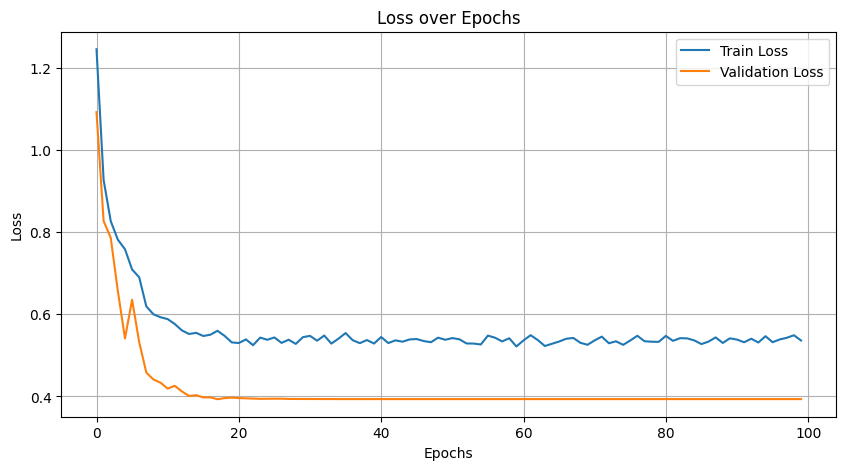

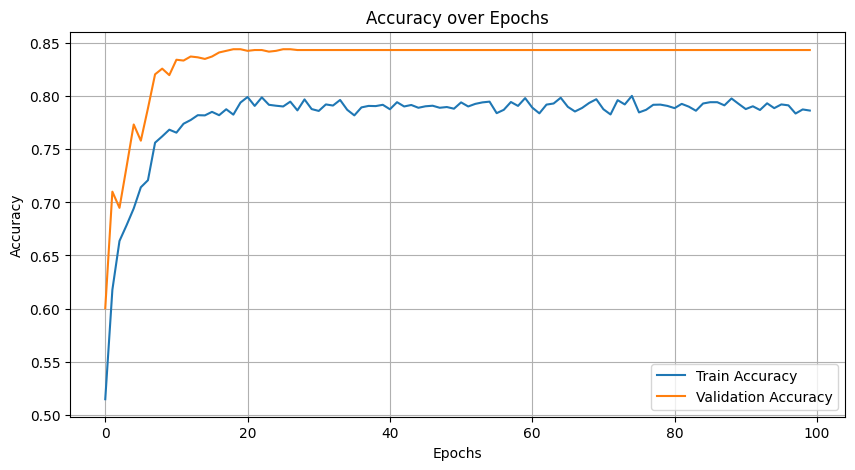

In [ ]:
import pickle
import matplotlib.pyplot as plt

from google.colab import drive
# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)

# Metrikleri yükleme
with open('/content/drive/MyDrive/cnn/metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Loss grafiği
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy grafiği
plt.figure(figsize=(10, 5))
plt.plot([acc.item() for acc in metrics['train_acc']], label='Train Accuracy')
plt.plot([acc.item() for acc in metrics['val_acc']], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Mounted at /content/drive


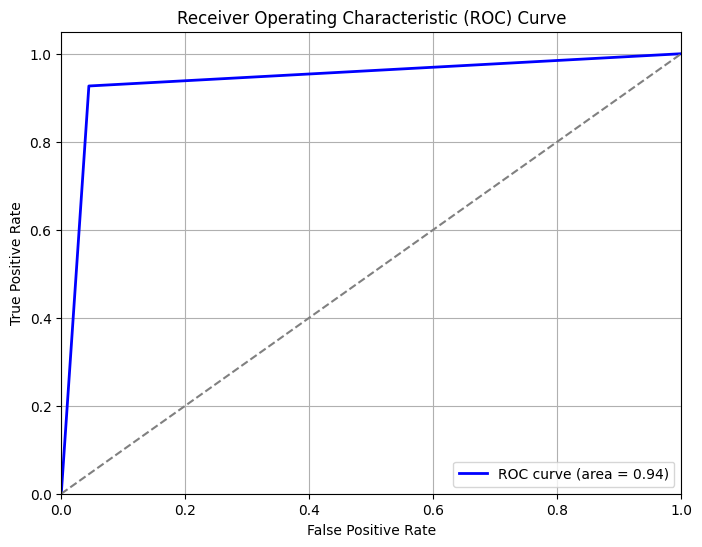

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from google.colab import drive
# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)


# 'metrics.pkl' dosyasından verileri oku
with open('/content/drive/MyDrive/cnn100/metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

# FPR ve TPR verilerini al
fpr = metrics['fpr'][-1]  # Son epoch için FPR
tpr = metrics['tpr'][-1]  # Son epoch için TPR
roc_auc = metrics['roc_auc'][-1]  # Son epoch için ROC AUC

# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import pickle
from google.colab import drive
# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)


import pickle

# 'metrics.pkl' dosyasından verileri oku
with open('/content/drive/MyDrive/cnn100/metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Anahtarlar ve değerlerini yazdırma
for key, value in metrics.items():
    print(f"{key}: {value}")

Mounted at /content/drive
train_acc: [tensor(0.5145, device='cuda:0', dtype=torch.float64), tensor(0.6176, device='cuda:0', dtype=torch.float64), tensor(0.6637, device='cuda:0', dtype=torch.float64), tensor(0.6786, device='cuda:0', dtype=torch.float64), tensor(0.6943, device='cuda:0', dtype=torch.float64), tensor(0.7143, device='cuda:0', dtype=torch.float64), tensor(0.7209, device='cuda:0', dtype=torch.float64), tensor(0.7563, device='cuda:0', dtype=torch.float64), tensor(0.7623, device='cuda:0', dtype=torch.float64), tensor(0.7686, device='cuda:0', dtype=torch.float64), tensor(0.7658, device='cuda:0', dtype=torch.float64), tensor(0.7742, device='cuda:0', dtype=torch.float64), tensor(0.7777, device='cuda:0', dtype=torch.float64), tensor(0.7822, device='cuda:0', dtype=torch.float64), tensor(0.7820, device='cuda:0', dtype=torch.float64), tensor(0.7854, device='cuda:0', dtype=torch.float64), tensor(0.7822, device='cuda:0', dtype=torch.float64), tensor(0.7878, device='cuda:0', dtype=torch.

In [ ]:
import pickle
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)

# 'metrics.pkl' dosyasını yükle
metrics_path = '/content/drive/MyDrive/cnn100/metrics.pkl'
cpu_metrics_path = '/content/drive/MyDrive/cnn100/metrics_cpu.pkl'

with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

# Tüm metriklerin CPU'da olduğundan emin ol
for key, value in metrics.items():
    if isinstance(value, list):
        metrics[key] = [v.cpu().numpy() if hasattr(v, 'cpu') else v for v in value]
    elif hasattr(value, 'cpu'):
        metrics[key] = value.cpu().numpy()

# CPU uyumlu metrikleri kaydet
with open(cpu_metrics_path, 'wb') as f:
    pickle.dump(metrics, f)

print(f"Metrics saved to {cpu_metrics_path}")


Mounted at /content/drive
Metrics saved to /content/drive/MyDrive/cnn100/metrics_cpu.pkl


In [ ]:
import copy
import os
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, matthews_corrcoef, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from transformers import AutoImageProcessor, CvtModel, CvtConfig

from google.colab import drive
# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)

# Hiperparametreler
data_dir = '/content/drive/MyDrive/Data'
batch_size = 64
num_epochs = 100
learning_rate = 0.0005

# CvT Model ve Image Processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")
config = CvtConfig.from_pretrained("microsoft/cvt-13")  # Konfigürasyonu al
model = CvtModel.from_pretrained("microsoft/cvt-13", config=config).to("cuda")

# Veri dönüşümleri
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Veri setlerinin yüklenmesi
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)  # Sınıf sayısını otomatik olarak ayarla

# Cihazı ayarlama
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Sınıflandırma Başlığı Eklenmesi
class CvTClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CvTClassifier, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(config.hidden_size, num_classes)  # Burada hidden_size'ı config'ten alıyoruz

    def forward(self, pixel_values):
        outputs = self.base_model(pixel_values=pixel_values)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(pooled_output)
        return logits

# CvT modelini sınıflandırıcı ile genişletme
model = CvTClassifier(model, num_classes).to(device)

# Kayıp fonksiyonu ve optimize edici
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)  # Recall
    specificity = tn / (tn + fp)  # Specificity
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    # FPR, TPR hesaplama
    fpr, tpr, _ = roc_curve(true_labels, pred_labels, pos_label=1)
    auc_score = auc(fpr, tpr)

    return accuracy, precision, recall, f1, specificity, sensitivity, fpr, tpr, auc_score

# Eğitim fonksiyonu
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Metriklerin kaydedilmesi
    metrics_history = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'sensitivity': [], 'auc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            true_labels = []
            pred_labels = []

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # CvT modeli için input dönüşümü
                    inputs = image_processor(images=inputs, return_tensors="pt")['pixel_values'].to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Gerçek ve tahmin etiketlerini kaydet
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Metrikleri hesapla
            accuracy, precision, recall, f1, specificity, sensitivity, fpr, tpr, auc_score = calculate_metrics(true_labels, pred_labels)

            metrics_history['accuracy'].append(accuracy)
            metrics_history['precision'].append(precision)
            metrics_history['recall'].append(recall)
            metrics_history['f1'].append(f1)
            metrics_history['specificity'].append(specificity)
            metrics_history['sensitivity'].append(sensitivity)
            metrics_history['auc'].append(auc_score)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f} Precision: {precision:.4f} Recall: {recall:.4f} AUC: {auc_score:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    return model, metrics_history

if __name__ == "__main__":
    model, metrics_history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Mounted at /content/drive


AttributeError: 'CvtConfig' object has no attribute 'hidden_size'